In [1]:
import sys

if ".." not in sys.path:
    sys.path.append("..")

In [2]:
import pickle 

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import networkx as nx
import cobra

from pprint import pp
from molmass import Formula
from cobra.io import read_sbml_model
from experiments.fast_dFBA import ConstantBounds
from utils.cobra_utils import get_or_create_exchange
from parameters.drawdown import *
from plotting.diagnostic import uptakes_and_secretions, plot_pathway, plot_metabolite_fluxes


MODEL_FILE = "../model/Rpom_05.xml"
BIOMASS_ID = "Rpom_hwa_biomass"
DATA_FILE = "../data/clean/CUE2/dFBA.pkl"


# Load and set up model
model = read_sbml_model(MODEL_FILE)

# Set maintenance to 25 mmol/gDW/h
atpm = model.reactions.get_by_id("ATPM")
atpm.bounds = (25, 25)

ex_glc = model.reactions.get_by_id("EX_glc")
ex_ace = get_or_create_exchange(model, "ACET[e]")

In [3]:
df = pd.read_excel("../data/raw/growth/essentiality - July 2023.xlsx")
df = df[~df["Mutant (yes/no)"].isna()]
df["Essential"] = (df["Mutant (yes/no)"] == "no")

In [4]:
# Get fluxes when running on glucose, acetate
with model:
    ex_glc.bounds = (-10, 0)
    sol_glc = model.optimize()
    mu_glc = sol_glc.objective_value
    model.summary()
    print(f"Glucose growth: {sol_glc.objective_value:.2f}")

Glucose growth: 0.76


In [5]:
# We need to create a mapping from model genes to (index of) data genes
model_to_data_genes = {}

# Most genes in the model are ID'd by their RefSeq locus tag:
print(f"Model has {len(model.genes)} genes")

matched_by_rs_locus_tag = {}
for gene in model.genes:
    if "_RS" not in gene.id:
        continue

    match = (df[df["RefSeq_locus_tag"] == gene.id]
                if gene.id in df["RefSeq_locus_tag"].values
                else None)
    if match is not None:
        assert len(match) == 1
        matched_by_rs_locus_tag[gene] = match.index[0]

model_to_data_genes.update(matched_by_rs_locus_tag)
print(f"Model has {len([gene for gene in model.genes if "_RS" in gene.id])} genes ID'd by RefSeq locus tags")
print(f"{len(matched_by_rs_locus_tag)} genes in the model can be matched to essentiality data by RefSeq locus tag")

Model has 862 genes
Model has 705 genes ID'd by RefSeq locus tags
703 genes in the model can be matched to essentiality data by RefSeq locus tag


In [6]:
# Try locus tag for the remaining genes
remaining_genes = {gene for gene in model.genes if gene not in model_to_data_genes}

matched_by_locus_tag = {}
for gene in remaining_genes:
    if gene.id in df["locus_tag"].values:
        match = df[df["locus_tag"] == gene.id].index[0]
        matched_by_locus_tag[gene] = match

model_to_data_genes.update(matched_by_locus_tag)
print(f"Of the {len(remaining_genes)} remaining genes not ID'd by RefSeq locus tag, {len(matched_by_locus_tag)} can be matched by locus tag")

Of the 159 remaining genes not ID'd by RefSeq locus tag, 69 can be matched by locus tag


In [7]:
remaining_genes = {gene for gene in model.genes if gene not in model_to_data_genes}
lefts = [float(gene.annotation["left-end-position"]) for gene in remaining_genes]
rights = [float(gene.annotation["right-end-position"]) for gene in remaining_genes]

# Try to match by position for the remaining genes
matched_by_position = {}
for gene, left, right in zip(remaining_genes, lefts, rights):
    matches = df[((df["start"] == left) & (df["stop"] == right)) 
                 | (df["start"] == right) & (df["stop"] == left)]
    if len(matches) == 1:
        print(f"{gene} matched by position to {matches['locus_tag'].values[0]}")
        matched_by_position[gene] = matches.index[0]

model_to_data_genes.update(matched_by_position)

print(f"{len(matched_by_position)} out of {len(remaining_genes)} genes matched by position,")
print(f"\tleaving {len(remaining_genes) - len(matched_by_position)} genes unmatched.")

G1RHL-2592 matched by position to SPO3411
G1RHL-1483 matched by position to SPO1967
G1RHL-1876 matched by position to SPO2487
G1RHL-24 matched by position to SPO0042
G1RHL-1167 matched by position to SPO1565
G1RHL-2021 matched by position to SPO2662
G1RHL-2048 matched by position to SPO2697
G1RHL-793 matched by position to SPO1107
G1RHL-2651 matched by position to SPO3482
G1RHL-1194 matched by position to SPO1595
G1RHL-489 matched by position to SPO0713
G1RHL-2727 matched by position to SPO3597
G1RHL-2356 matched by position to SPO3089
G1RHL-2850 matched by position to SPO3903
G1RHL-1974 matched by position to SPO2607
G1RHL-2528 matched by position to SPO3327
G1RHL-1999 matched by position to SPO2637
G1RHL-1193 matched by position to SPO1594
G1RHL-2130 matched by position to SPO2806
G1RHL-2087 matched by position to SPO2739
G1RHL-2244 matched by position to SPO2957
G1RHL-1780 matched by position to SPO2370
G1RHL-2827 matched by position to SPO3719
G1RHL-558 matched by position to SPO08

In [8]:
print("Remaining genes:")
remaining_genes = set(remaining_genes) - set(matched_by_position.keys())
for gene in remaining_genes:
    print(f"{gene.id} ({gene.annotation})")

Remaining genes:
G1RHL-3127 ({'source': 'Ruegeria pomeroyi DSS-3', 'left-end-position': '4378836', 'right-end-position': '4380011', 'replicon': 'DSS3'})
G1RHL-3144 ({'source': 'Ruegeria pomeroyi DSS-3', 'left-end-position': '4401637', 'right-end-position': '4402578', 'replicon': 'DSS3'})
SPO_RS01365 ({'source': 'Ruegeria pomeroyi DSS-3 representative genome', 'synonyms': "['RS01365']", 'left-end-position': '285959', 'right-end-position': '286399', 'replicon': 'NC_003911'})
G1RHL-2947 ({'source': 'Ruegeria pomeroyi DSS-3', 'left-end-position': '4109488', 'right-end-position': '4110285', 'replicon': 'DSS3'})
G1RHL-3161 ({'source': 'Ruegeria pomeroyi DSS-3', 'left-end-position': '4424979', 'right-end-position': '4426991', 'replicon': 'DSS3'})
G1RHL-3123 ({'source': 'Ruegeria pomeroyi DSS-3', 'left-end-position': '4374253', 'right-end-position': '4375176', 'replicon': 'DSS3'})
G1RHL-3135 ({'source': 'Ruegeria pomeroyi DSS-3', 'left-end-position': '4388978', 'right-end-position': '4389739',

 32%|███▏      | 267/846 [00:11<00:25, 22.40it/s]/home/mica/.pyenv/versions/3.12.1/envs/rpom/lib/python3.12/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
100%|██████████| 846/846 [00:34<00:00, 24.24it/s]


(array([118.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   3., 724.]),
 array([-7.08097061e-12,  1.00000000e-01,  2.00000000e-01,  3.00000000e-01,
         4.00000000e-01,  5.00000000e-01,  6.00000000e-01,  7.00000000e-01,
         8.00000000e-01,  9.00000000e-01,  1.00000000e+00]),
 <BarContainer object of 10 artists>)

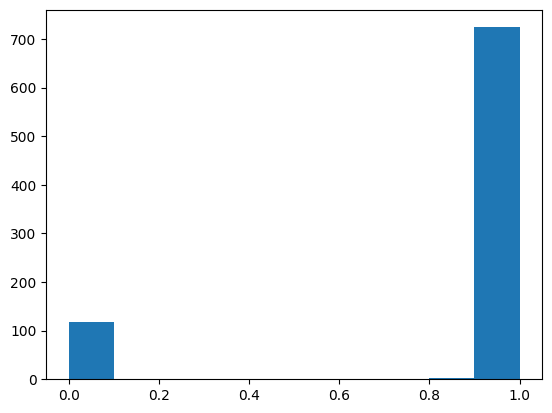

In [9]:
# Time to do the essentiality tests!!!
from tqdm import tqdm

with model:
    ex_glc.bounds = (-10, 0)
    sol = model.optimize()
    baseline = sol.objective_value

growth_rates = []
essentialities = []
for gene, index in tqdm(model_to_data_genes.items()):
    # Retrieve whether the gene is experimentally essential
    essential = df.loc[index]["Essential"]
    essentialities.append(essential)

    # Get model growth rate
    with model:
        ex_glc.bounds = (-10, 0)
        gene.knock_out()
        sol = model.optimize()
        growth_rates.append(sol.objective_value)
growth_rates = np.array(growth_rates)

fig, ax = plt.subplots()
ax.hist(growth_rates / baseline)

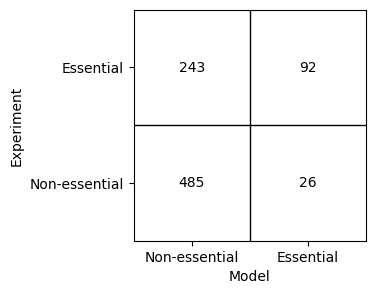

In [10]:
from collections import Counter

model_essential = (growth_rates < 1e-6)

fig, ax = plt.subplots()
for (model_x, data_y), count in Counter(zip(model_essential, essentialities)).items():
    ax.text(model_x/2 + 0.25,
            data_y/2 + 0.25,
            str(count),
            ha="center",
            va="center")

ax.vlines(0.5, 0, 1, "k", lw=1)
ax.hlines(0.5, 0, 1, "k", lw=1)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_xticks([.25, .75], ["Non-essential", "Essential"])
ax.set_yticks([.25, .75], ["Non-essential", "Essential"])
ax.set_xlabel("Model")
ax.set_ylabel("Experiment")

fig.set_size_inches(3, 3)

In [15]:
# Now, let's run a reaction essentiality test, so that we can relate the gene essentiality to the reaction essentiality
reaction_essentialities = []
for reaction in tqdm(model.reactions):
    with model:
        ex_glc.bounds = (-10, 0)
        reaction.knock_out()
        sol = model.optimize()
        reaction_essentialities.append(sol.objective_value)
reaction_essentialities = np.array(reaction_essentialities)
reaction_essentialities = reaction_essentialities < 1e-6
reaction_essentialities = dict(zip(model.reactions, reaction_essentialities))

  0%|          | 0/1801 [00:00<?, ?it/s]

 12%|█▏        | 214/1801 [00:05<00:34, 45.63it/s]/home/mica/.pyenv/versions/3.12.1/envs/rpom/lib/python3.12/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
100%|██████████| 1801/1801 [00:50<00:00, 35.49it/s]


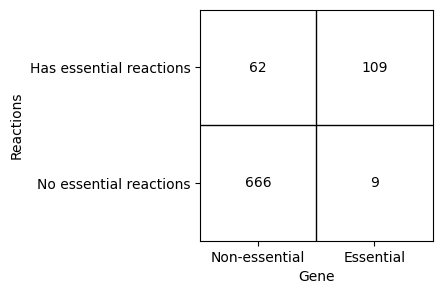

In [31]:
# Now we can relate the gene essentiality to the reaction essentiality
gene_reaction_categories = Counter()
strange = []
for gene, essentiality in zip(model_to_data_genes, model_essential):
    reactions = gene.reactions
    gene_reaction_essentialities = [reaction_essentialities[reaction] for reaction in reactions]
    has_essential_reactions = any(gene_reaction_essentialities)

    gene_reaction_categories[(essentiality, has_essential_reactions)] += 1

    if essentiality and not has_essential_reactions:
        strange.append(gene)

fig, ax = plt.subplots()
for (model_x, data_y), count in gene_reaction_categories.items():
    ax.text(model_x/2 + 0.25,
            data_y/2 + 0.25,
            str(count),
            ha="center",
            va="center")
ax.vlines(0.5, 0, 1, "k", lw=1)
ax.hlines(0.5, 0, 1, "k", lw=1)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_xticks([.25, .75], ["Non-essential", "Essential"])
ax.set_yticks([.25, .75], ["No essential reactions", "Has essential reactions"])
ax.set_xlabel("Gene")
ax.set_ylabel("Reactions")
fig.set_size_inches(3, 3)


In [30]:
for gene in strange:
    print(f"{gene.id}\n====================")
    for reaction in gene.reactions:
        print(f"\t{reaction.id} ({reaction_essentialities[reaction]})")

SPO_RS18880
	RXN-15200 (False)
	CYSTEINE-AMINOTRANSFERASE-RXN (False)
	RXN-10814 (False)
	ASPAMINOTRANS-RXN (False)
	2.6.1.57-RXN-PHE/2-KETOGLUTARATE//PHENYL-PYRUVATE/GLT.41. (False)
	RXN-11737 (False)
	TRYPTOPHAN-AMINOTRANSFERASE-RXN (False)
	RXN-13697 (False)
	TYROSINE-AMINOTRANSFERASE-RXN (False)
SPO_RS06955
	5.4.2.10-RXN (False)
	5.4.2.10-RXN-CPD-13469//GLUCOSAMINE-1P.26. (False)
SPO_RS04500
	AIRCARBOXY-RXN (False)
	RXN0-743 (False)
SPO_RS08825
	HOMOSERDEHYDROG-RXN-HOMO-SER/NADP//L-ASPARTATE-SEMIALDEHYDE/NADPH/PROTON.53. (False)
	HOMOSERDEHYDROG-RXN-HOMO-SER/NAD//L-ASPARTATE-SEMIALDEHYDE/NADH/PROTON.51. (False)
SPO_RS08800
	HOMSUCTRAN-RXN (False)
	HOMOSERINE-O-ACETYLTRANSFERASE-RXN (False)
SPO_RS16245
	RXN0-884 (False)
	ISPH2-RXN (False)
SPO_RS02155
	NAD-SYNTH-NH3-RXN (False)
	NAD-SYNTH-GLN-RXN (False)
SPO_RS16005
	PRPPSYN-RXN-CPD-16551/ATP//PRPP/AMP/PROTON.31. (False)
	PRPPSYN-RXN-CPD-15895/ATP//PRPP/AMP/PROTON.31. (False)
	PRPPSYN-RXN-CPD-15318/ATP//PRPP/AMP/PROTON.31. (False)
	P

In [26]:
# Check SPO_RS14555
gene = model.genes.get_by_id("SPO_RS14555")
with model:
    ex_glc.bounds = (-10, 0)
    gene.knock_out()
    sol = model.optimize()
    print(sol.objective_value)

0.7622464363356171
